# Scraping Data from Deutscher Wetterdienst (DWD)
CDC = Climate Data Center

We are only going to look at the **recent** data provided by DWD, which includes the last 500 days until yesterday.

## Hints
- _product file_ = the file that contains the data we are looking for, in this case the recent hourly measurements of temperature and humidity of _one_ station
- _quality_ = quality level of the data assigned by DWD (1 - worst, 10 - best)





In [7]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from zipfile import ZipFile
import os
import datetime
import shutil

In [8]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [9]:
DATA_DIR = "retrieved_data/"
EXPORT_DIR = "exported_data/"

In [10]:
URL_hourly_recent = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/recent/"
URL_station_info = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/recent/TU_Stundenwerte_Beschreibung_Stationen.txt"

## Load the list of weather stations

In [12]:
def parse_weather_station_info(text):
    data = []
    for line in text[2:]:
        e = line.split()
        station_id = e.pop(0)
        start_date = e.pop(0)
        end_date = e.pop(0)
        altitude = e.pop(0)
        latitude = e.pop(0)
        longitude = e.pop(0)
        state = e.pop(-1)
        station_name = " ".join(e)

        row = [station_id, start_date, end_date, altitude, latitude, longitude, station_name, state]
        data.append(row)

    columns = ["station_id", "start_date", "end_date", "altitude", "latitude", "longitude", "name", "state"]
    df = pd.DataFrame(data, columns=columns)
    return df

req = requests.get(URL_station_info)
lines = req.text.splitlines()
df1 = parse_weather_station_info(lines)

# convert columns to numeric 
df1 = df1.apply(pd.to_numeric, errors="ignore")

# convert dates into datetime objects
df1[["start_date", "end_date"]] = df1[["start_date", "end_date"]].apply(pd.to_datetime, format="%Y%m%d")

#df1.to_excel(EXPORT_DIR + "stations.xlsx")
df1.to_csv(EXPORT_DIR + "stations.csv")
df1

,station_id,start_date,end_date,altitude,latitude,longitude,name,state
0,3,1950-04-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1,44,2007-04-01,2020-03-25,44,52.9336,8.2370,Großenkneten,Niedersachsen
2,52,1976-01-01,1988-01-01,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
3,71,2009-12-01,2020-01-02,759,48.2156,8.9784,Albstadt-Badkap,Baden-Württemberg
4,73,2007-04-01,2020-03-25,340,48.6159,13.0506,Aldersbach-Kriestorf,Bayern
...,...,...,...,...,...,...,...,...
653,14138,2009-09-15,2015-12-31,73,52.1655,14.1224,Falkenberg (Grenzschichtmessfeld),Brandenburg
654,15000,2011-04-01,2020-03-25,231,50.7983,6.0244,Aachen-Orsbach,Nordrhein-Westfalen
655,15207,2013-11-01,2020-03-25,317,51.2835,9.3590,Schauenburg-Elgershausen,Hessen
656,15444,2014-09-01,2020-03-25,593,48.4418,9.9216,Ulm-Mähringen,Baden-Württemberg


## Scrape all zip links that are available

In [6]:
def scrape_product_links(soup):
    anchors = soup.find_all("a")
    links = []
    
    for a in anchors:
        ref = a.get("href")
        if ref.startswith("stundenwerte_TU_") and ref.endswith("_akt.zip"):
            links.append(ref)
    return links

req = requests.get(URL_hourly_recent)
soup = BeautifulSoup(req.content, "html.parser")
file_urls = scrape_product_links(soup)
    

## Download all zip files

In [11]:
def download_all_product_files(file_urls):
    total = len(file_urls)
    for i, url in enumerate(file_urls, start=1):
        req = requests.get(URL_hourly_recent + url)

        with open(DATA_DIR + url, "wb") as file:
            file.write(req.content)
            
        # unzip the file and only keep the extracted content
        with ZipFile(DATA_DIR + url, "r") as zippy:
            dirname = DATA_DIR + url[:-4]
            if os.path.isdir(dirname):
                shutil.rmtree(dirname)
            try:
                os.mkdir(dirname)
                zippy.extractall(dirname)
                os.remove(DATA_DIR + url)
            except Exception as e:
                print(e)
        
        if i % 50 == 0 or i == total:
            print("%d of %d files downloaded" % (i , total))
    
download_all_product_files(file_urls)

50 of 508 files downloaded
100 of 508 files downloaded
150 of 508 files downloaded
200 of 508 files downloaded
250 of 508 files downloaded
300 of 508 files downloaded
350 of 508 files downloaded
400 of 508 files downloaded
450 of 508 files downloaded
500 of 508 files downloaded
508 of 508 files downloaded


## Extract temperature und humidity data from all station data
Now, for every available weather station there exists a folder containing measurement as well as meta data about the corresponding station.

### Get all directories that were downloaded

In [12]:
def get_directories(path, prefix, suffix):
    dir_list = []

    dir_iter = os.scandir(path)
    for i in dir_iter:
        if i.is_dir():
            name = i.name
            if name.startswith(prefix) and name.endswith(suffix):
                dir_list.append(name + "/")
    return dir_list



                
                
dir_list = get_directories(DATA_DIR, "stundenwerte_", "_akt")
dir_list

['stundenwerte_TU_01297_akt/',
 'stundenwerte_TU_05797_akt/',
 'stundenwerte_TU_03319_akt/',
 'stundenwerte_TU_06275_akt/',
 'stundenwerte_TU_02985_akt/',
 'stundenwerte_TU_01526_akt/',
 'stundenwerte_TU_07396_akt/',
 'stundenwerte_TU_07369_akt/',
 'stundenwerte_TU_02211_akt/',
 'stundenwerte_TU_07341_akt/',
 'stundenwerte_TU_07427_akt/',
 'stundenwerte_TU_01863_akt/',
 'stundenwerte_TU_02601_akt/',
 'stundenwerte_TU_05146_akt/',
 'stundenwerte_TU_02629_akt/',
 'stundenwerte_TU_03244_akt/',
 'stundenwerte_TU_03278_akt/',
 'stundenwerte_TU_02600_akt/',
 'stundenwerte_TU_04271_akt/',
 'stundenwerte_TU_06314_akt/',
 'stundenwerte_TU_03287_akt/',
 'stundenwerte_TU_01645_akt/',
 'stundenwerte_TU_03734_akt/',
 'stundenwerte_TU_07432_akt/',
 'stundenwerte_TU_03126_akt/',
 'stundenwerte_TU_03668_akt/',
 'stundenwerte_TU_07368_akt/',
 'stundenwerte_TU_03442_akt/',
 'stundenwerte_TU_01255_akt/',
 'stundenwerte_TU_06260_akt/',
 'stundenwerte_TU_02953_akt/',
 'stundenwerte_TU_02947_akt/',
 'stunde

### Product file data extraction
Extract the data provided in one product file (i.e. hourly recent temperature + humidity for station-id)

In [13]:
# get all files that were contained in the zip and find the product file
def get_files(path, prefix, suffix, exactly_one=False):
    file_list = []

    dir_iter = os.scandir(path)
    for i in dir_iter:
        if i.is_file():
            name = i.name
            if name.startswith(prefix) and name.endswith(suffix):
                file_list.append(name)
    
    if exactly_one is True:
        if len(file_list) == 1:
            return file_list[0]
        elif len(file_list) > 1:
            raise Exception("There seem to exist two product files for the same station!")
        else:
            raise Exception("No product file found!")
    else:
        return file_list


dirname = DATA_DIR + "stundenwerte_TU_00073_akt/"
product_name = get_files(dirname, "produkt_tu_stunde_", ".txt", exactly_one=True)


# extract the data from the text file
def product_file_to_dataframe(file_path):
    text = None
    with open(file_path, "r") as file:
        text = file.read().splitlines()


    data = []
    for line in text[1:]:
        row = line.split(";")
        values = [value.strip() for value in row]
        values.pop()
        data.append(values)

    colnames = ["station_id", "date", "quality", "temperature", "humidity"]
    df = pd.DataFrame(data, columns=colnames)
    return df

product_path = dirname + product_name
df = product_file_to_dataframe(product_path)
df

,station_id,date,quality,temperature,humidity
0,73,2018092300,3,11.6,93.0
1,73,2018092301,3,11.5,97.0
2,73,2018092302,3,11.4,95.0
3,73,2018092303,3,11.7,97.0
4,73,2018092304,3,11.6,89.0
...,...,...,...,...,...
13195,73,2020032519,1,1.4,54.0
13196,73,2020032520,1,0.5,59.0
13197,73,2020032521,1,0.4,58.0
13198,73,2020032522,1,0.2,60.0


### Iterate over all downloaded directories and collect the data

In [14]:
frames = []
for folder_name in dir_list:
    path = DATA_DIR + folder_name
    # find product file name
    product_file = get_files(path, "produkt_tu_stunde_", ".txt", exactly_one=True)
    product_file = path + product_file
    # extract the data from this file
    df = product_file_to_dataframe(product_file)
    
    frames.append(df)

# concatenate all the frames into one frame
df = pd.concat(frames)

### Data Cleaning
- convert columns into numerical values
- convert date column into datetime format
- remove error entries

In [15]:
df = df.apply(pd.to_numeric)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d%H")

df.loc[df["temperature"] == -999, "temperature"] = float("NaN")
df.loc[df["humidity"] == -999, "humidity"] = float("NaN")

In [16]:
df.groupby(["station_id"]).mean().sort_values("temperature", ascending=False)

,quality,temperature,humidity
station_id,,,
3044,3.000000,22.675000,74.041667
4154,3.000000,21.600000,46.000000
2829,3.000000,15.100000,78.285714
555,3.000000,11.452137,77.721154
96,2.584785,11.207089,74.766964
...,...,...,...
1346,2.734545,3.985524,77.649935
1358,2.734545,3.698506,82.455304
722,2.734545,3.611864,84.230530


In [53]:
df

,station_id,date,quality,temperature,humidity
0,1297,2018-09-23 00:00:00,3,10.6,90.0
1,1297,2018-09-23 01:00:00,3,10.6,90.0
2,1297,2018-09-23 02:00:00,3,10.5,92.0
3,1297,2018-09-23 03:00:00,3,10.6,92.0
4,1297,2018-09-23 04:00:00,3,10.5,92.0
...,...,...,...,...,...
13195,5017,2020-03-25 19:00:00,1,0.3,34.0
13196,5017,2020-03-25 20:00:00,1,0.0,37.0
13197,5017,2020-03-25 21:00:00,1,-0.1,40.0
13198,5017,2020-03-25 22:00:00,1,-0.8,45.0


## Nächste Schritte
- Datetime Format integrieren
- nur 12-Uhr Messungen plotten
- Locations integrieren








## Plot some data

In [81]:
df.loc[(df["date"].dt.hour == 12) & (df["date"].dt.month == 7)].groupby("date").mean()

,station_id,quality,temperature,humidity
date,,,,
2019-07-01 12:00:00,3733.896341,3.0,25.733401,46.737271
2019-07-02 12:00:00,3728.257606,3.0,20.836660,46.535642
2019-07-03 12:00:00,3733.896341,3.0,20.012016,42.885947
2019-07-04 12:00:00,3730.807302,3.0,21.171341,40.455285
2019-07-05 12:00:00,3732.754065,3.0,22.479022,45.824847
2019-07-06 12:00:00,3733.018330,3.0,24.497955,42.893661
2019-07-07 12:00:00,3730.807302,3.0,17.726680,58.429735
2019-07-08 12:00:00,3735.894309,3.0,16.686939,54.957143
2019-07-09 12:00:00,3735.894309,3.0,16.461429,53.371429


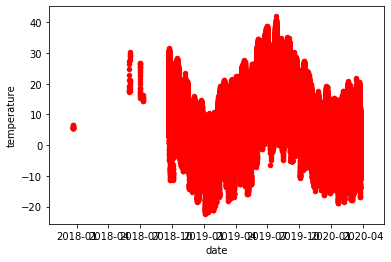

In [132]:
df.plot(kind="scatter", x="date", y="temperature", color="red")
plt.show()

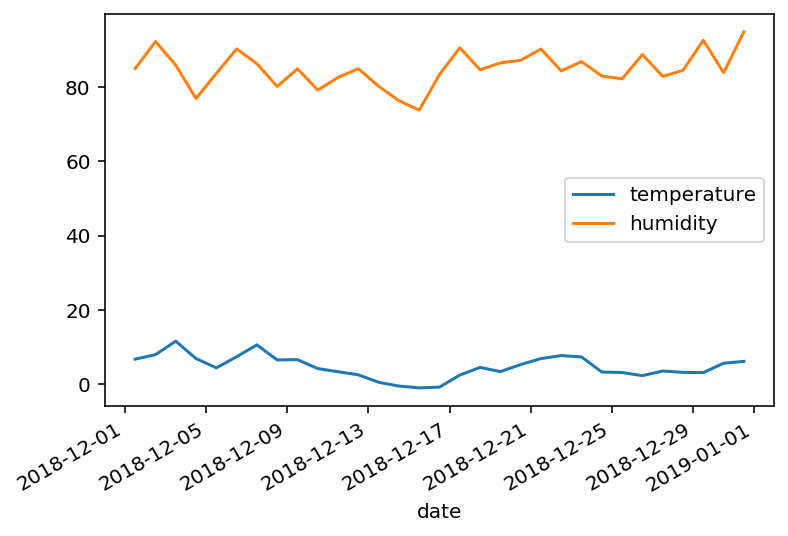

In [98]:
df.loc[(df["date"].dt.hour == 12) & (df["date"].dt.month == 12) & (df["date"].dt.year == 2018)].groupby("date").mean().plot(kind="line", y=["temperature", "humidity"])
plt.show()

In [135]:
df.groupby("station_id").mean()

,quality,temperature,humidity
station_id,,,
44,2.734545,9.435348,81.947197
71,3.000000,8.320327,76.323102
73,2.734545,8.495731,81.995112
78,2.734545,9.374553,80.925000
91,2.734545,8.402190,81.023184
...,...,...,...
13965,2.721949,7.674356,77.437536
15000,2.734545,9.662788,76.835833
15207,2.734545,8.519811,77.801733


In [141]:
df.head(50)


,station_id,date,quality,temperature,humidity
0,1297,2018-09-21 00:00:00,3,12.9,82.0
1,1297,2018-09-21 01:00:00,3,14.0,82.0
2,1297,2018-09-21 02:00:00,3,12.3,83.0
3,1297,2018-09-21 03:00:00,3,13.9,78.0
4,1297,2018-09-21 04:00:00,3,12.1,83.0
5,1297,2018-09-21 05:00:00,3,12.9,84.0
6,1297,2018-09-21 06:00:00,3,15.2,76.0
7,1297,2018-09-21 07:00:00,3,20.2,56.0
8,1297,2018-09-21 08:00:00,3,22.3,51.0
9,1297,2018-09-21 09:00:00,3,24.7,45.0
